## Bike Sharing Assignment

In [1]:
# importing the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

## Step 1: Reading and Understanding the data

In [2]:
# reading the data from csv
bike_rental_data = pd.read_csv('day.csv')
# overview of the data
bike_rental_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# renaming few columns to proper convention
bike_rental_data.rename(columns={'yr':'year','mnth':'month','dteday':'date'}, inplace=True)

In [4]:
# shape of the dframe
bike_rental_data.shape

(730, 16)

In [5]:
# convcerting season, weathersit, weekday, workingday, holiday to proper categorical string representation
bike_rental_data['season'] = bike_rental_data[['season']].apply(lambda x: x.map({1:"season_spring", 2:"season_summer", 3:"season_fall", 4:"season_winter"}))
bike_rental_data['weathersit'] = bike_rental_data[['weathersit']].apply(lambda x: x.map({1:"weathersit_clear", 2:"weathersit_mist", 3:"weathersit_light_rain", 4:"weathersit_heavy_rain"}))
bike_rental_data['weekday'] = bike_rental_data[['weekday']].apply(lambda x: x.map({0:"weekday_sun", 1:"weekday_mon", 2:"weekday_tue", 3:"weekday_wed", 4:"weekday_thu",5:"weekday_fri", 6:"weekday_sat"}))
bike_rental_data['month'] = bike_rental_data[['month']].apply(lambda x: x.map({1:"month_jan", 2:"month_feb", 3:"month_mar", 4:"month_apr", 5:"month_may",6:"month_june", 7:"month_july", 8:"month_aug", 9:"month_sep", 10: "month_oct", 11:"month_nov", 12:"month_dec"}))

In [6]:
# overview of the data post conversion
bike_rental_data.head()

,instant,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,season_spring,0,month_jan,0,weekday_sat,0,weathersit_mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,season_spring,0,month_jan,0,weekday_sun,0,weathersit_mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,season_spring,0,month_jan,0,weekday_mon,1,weathersit_clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,season_spring,0,month_jan,0,weekday_tue,1,weathersit_clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,season_spring,0,month_jan,0,weekday_wed,1,weathersit_clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [7]:
# checking if any null values
bike_rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   date        730 non-null    object 
 2   season      730 non-null    object 
 3   year        730 non-null    int64  
 4   month       730 non-null    object 
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    object 
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    object 
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 91.4+ KB


In [8]:
# statistical info about the dataset 
bike_rental_data.describe()

,instant,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.500000,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,0.500343,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [9]:
# columns in dframe
bike_rental_data.columns

Index(['instant', 'date', 'season', 'year', 'month', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

### Visualizing the dataset

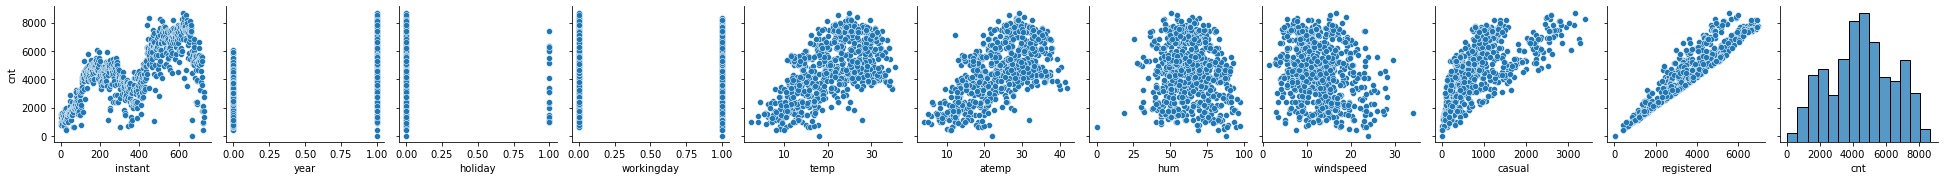

In [10]:
# visualizing the numeric variables
sns.pairplot(y_vars='cnt', data=bike_rental_data)
plt.show()

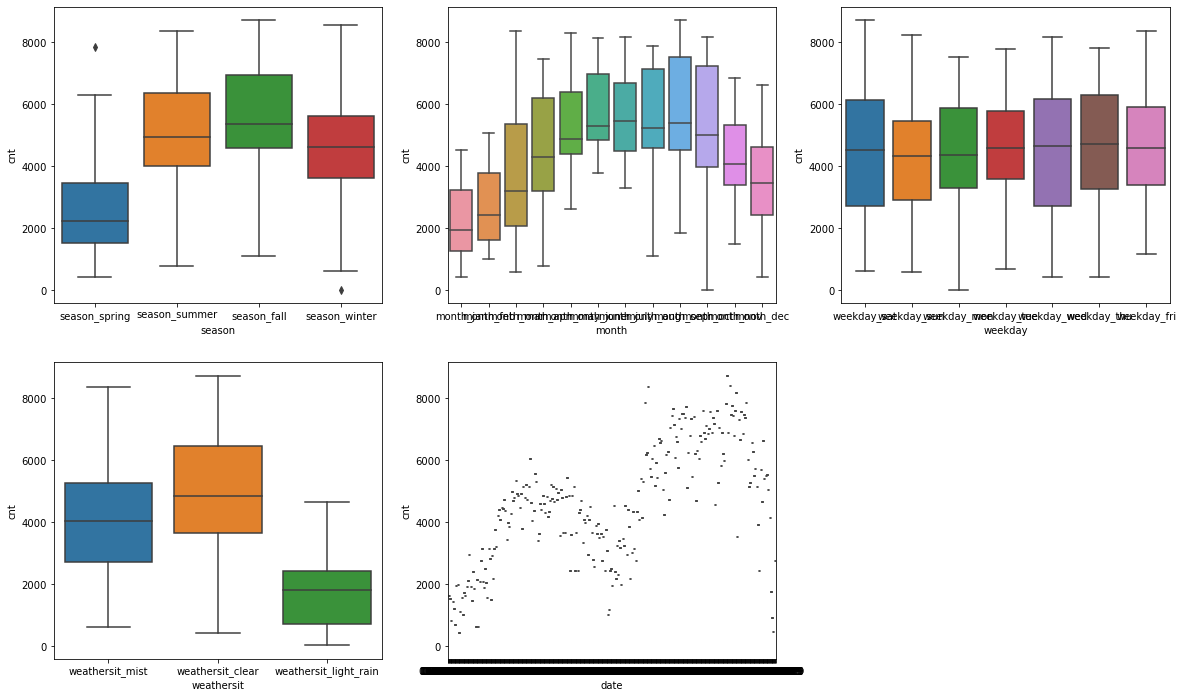

In [11]:
# visualizing the categorical variables against the cnt
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x='season', y='cnt', data=bike_rental_data)
plt.subplot(2,3,2)
sns.boxplot(x='month', y='cnt', data=bike_rental_data)
plt.subplot(2,3,3)
sns.boxplot(x='weekday', y='cnt', data=bike_rental_data)
plt.subplot(2,3,4)
sns.boxplot(x='weathersit', y='cnt', data=bike_rental_data)
plt.subplot(2,3,5)
sns.boxplot(x='date', y='cnt', data=bike_rental_data)
plt.show()

In [12]:
# dropping the columns instant, date since instant is just for serial no and date is also not driving any such variation
bike_rental_data.drop(columns=['instant','date'], inplace=True)

In [13]:
# overview of the data
bike_rental_data.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,season_spring,0,month_jan,0,weekday_sat,0,weathersit_mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,season_spring,0,month_jan,0,weekday_sun,0,weathersit_mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,season_spring,0,month_jan,0,weekday_mon,1,weathersit_clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,season_spring,0,month_jan,0,weekday_tue,1,weathersit_clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,season_spring,0,month_jan,0,weekday_wed,1,weathersit_clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Preparing the data
    - Creating dummy variables
    - Splitting the data into train test
    - Scaling the data

### Crearting dummy variables

In [14]:
# Creating dummy variables for columns: season, month, weekday, weathersit
df_season = pd.get_dummies(bike_rental_data['season'], drop_first=True)
df_month = pd.get_dummies(bike_rental_data['month'], drop_first=True)
df_weekday = pd.get_dummies(bike_rental_data['weekday'], drop_first=True)
df_weathersit = pd.get_dummies(bike_rental_data['weathersit'], drop_first=True)

In [15]:
# concatinating the dummy columns into original df
bike_rental_data = pd.concat([bike_rental_data, df_season,df_month,df_weekday,df_weathersit], axis=1)
bike_rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season                 730 non-null    object 
 1   year                   730 non-null    int64  
 2   month                  730 non-null    object 
 3   holiday                730 non-null    int64  
 4   weekday                730 non-null    object 
 5   workingday             730 non-null    int64  
 6   weathersit             730 non-null    object 
 7   temp                   730 non-null    float64
 8   atemp                  730 non-null    float64
 9   hum                    730 non-null    float64
 10  windspeed              730 non-null    float64
 11  casual                 730 non-null    int64  
 12  registered             730 non-null    int64  
 13  cnt                    730 non-null    int64  
 14  season_spring          730 non-null    uint8  
 15  season

In [16]:
# dropping the original categorical columns: season, month, weekday, weathersit
bike_rental_data.drop(['season', 'month', 'weekday', 'weathersit'],axis=1, inplace=True)

### Train-test split of the data

In [122]:
# train test split
df_train, df_test = train_test_split(bike_rental_data, train_size=0.7, random_state=100)
print(df_train.shape, df_test.shape)

(510, 32) (220, 32)


In [123]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   510 non-null    int64  
 1   holiday                510 non-null    int64  
 2   workingday             510 non-null    int64  
 3   temp                   510 non-null    float64
 4   atemp                  510 non-null    float64
 5   hum                    510 non-null    float64
 6   windspeed              510 non-null    float64
 7   casual                 510 non-null    int64  
 8   registered             510 non-null    int64  
 9   cnt                    510 non-null    int64  
 10  season_spring          510 non-null    uint8  
 11  season_summer          510 non-null    uint8  
 12  season_winter          510 non-null    uint8  
 13  month_aug              510 non-null    uint8  
 14  month_dec              510 non-null    uint8  
 15  mont

### Rescaling the features

In [124]:
# using min max scaling because it compresses outliers also
# instantiating the object
scaler = MinMaxScaler()

# list of numeric vars, not doing scaling on dummy and binary features since they are easier to interpret(0 and 1)
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered', 'cnt']

# fit and transhform the train data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [125]:
# post scaling
df_train.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light_rain,weathersit_mist
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.294422,0.899220,0.827658,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.290765,0.446145,0.465255,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.110332,0.203869,0.204096,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.340750,0.444701,0.482973,...,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.053337,0.214554,0.191095,...,0,0,0,0,0,0,0,0,0,1


In [126]:
df_train.describe()

,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light_rain,weathersit_mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.254689,0.523781,0.513499,...,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.206015,0.227896,0.224421,...,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.094179,0.353487,0.356420,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.212740,0.525123,0.518638,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.327415,0.696073,0.684710,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
# since the target feature cnt is derived from features casual 
# and registered removing these two from train set so that model is not bias and can learn on other features driving the variations
df_train.drop(['casual', 'registered'], axis=1, inplace=True)

## Initially creating a model with all the features

In [128]:
# splitting train data into X_train and Y_train(target feature)
Y_train = df_train.pop('cnt')
X_train = df_train

In [129]:
# adding constant to the train data
X_train_sm = sm.add_constant(X_train)

# creating the model using statsmodel
lr = sm.OLS(Y_train, X_train_sm)
lr_model = lr.fit()

# looking at the summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          2.81e-180
Time:                        10:13:14   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2433      0.035      6.887      0.000       0.174       0.313
year                      0.2325      0.008     28.794      0.000       0.217       0.248
holiday                   0.0109      0.024      0.451      0.652      -0.037       0.058
workingday                0.0963      0.012      7.835      0.000       0.072       0.120
temp                      0.3880      0.142      2.727      0.007       0.108       0.668
atemp                     0.0590      0.138      0.426      0.670      -0.213       0.331
hum                      -0.1520      0.039     -3.938      0.000      -0.228      -0.076
windspeed                -0.1836      0.026     -6.962      0.000      -0.235      -0.132
season_spring            -0.0454      0.030     -1.511      0.131      -0.104       0.014
season_summer             0.0424      0.026      1.617      0.107      -0.009       0.094
season_winter             0.1071      0.028      3.826      0.000       0.052       0.162
month_aug                 0.0223      0.034      0.657      0.511      -0.044       0.089
month_dec                -0.0443      0.034     -1.316      0.189      -0.110       0.022
month_feb                -0.0323      0.033     -0.980      0.327      -0.097       0.032
month_jan                -0.0631      0.034     -1.876      0.061      -0.129       0.003
month_july               -0.0327      0.035     -0.931      0.352      -0.102       0.036
month_june                0.0060      0.025      0.241      0.810      -0.043       0.055
month_mar                 0.0016      0.025      0.063      0.950      -0.047       0.050
month_may                 0.0255      0.021      1.208      0.228      -0.016       0.067
month_nov                -0.0398      0.036     -1.093      0.275      -0.111       0.032
month_oct                 0.0077      0.036      0.215      0.830      -0.063       0.078
month_sep                 0.0868      0.032      2.711      0.007       0.024       0.150
weekday_mon              -0.0216      0.015     -1.401      0.162      -0.052       0.009
weekday_sat               0.0952      0.014      6.910      0.000       0.068       0.122
weekday_sun               0.0410      0.014      2.929      0.004       0.013       0.068
weekday_thu              -0.0097      0.016     -0.623      0.534      -0.040       0.021
weekday_tue              -0.0184      0.016     -1.184      0.237      -0.049       0.012
weekday_wed              -0.0059      0.015     -0.394      0.694      -0.035       0.023
weathersit_light_rain    -0.2550      0.026     -9.631      0.000      -0.307      -0.203
weathersit_mist          -0.0595      0.010     -5.701      0.000      -0.080      -0.039
==============================================================================
Omnibus:                       84.

### Checking for the VIF

In [130]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,85.56
3,temp,66.90
4,atemp,56.03
22,weekday_sat,19.71
23,weekday_sun,18.34
7,season_spring,10.77
9,season_winter,9.46
8,season_summer,8.29
18,month_nov,6.79
10,month_aug,6.47


### Feature selection using RFE
#### Considering 15 approx features in RFE looking at the P-values and VIF obtained through above model buliding

In [131]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, Y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('month_aug', False, 7),
 ('month_dec', False, 3),
 ('month_feb', False, 4),
 ('month_jan', True, 1),
 ('month_july', True, 1),
 ('month_june', False, 14),
 ('month_mar', False, 15),
 ('month_may', False, 6),
 ('month_nov', False, 2),
 ('month_oct', False, 13),
 ('month_sep', True, 1),
 ('weekday_mon', False, 9),
 ('weekday_sat', True, 1),
 ('weekday_sun', False, 8),
 ('weekday_thu', False, 11),
 ('weekday_tue', False, 10),
 ('weekday_wed', False, 12),
 ('weathersit_light_rain', True, 1),
 ('weathersit_mist', True, 1)]

In [132]:
# selected cors according to RFE
selected_cols = X_train.columns[rfe.support_]
selected_cols

Index(['year', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'month_jan',
       'month_july', 'month_sep', 'weekday_sat', 'weathersit_light_rain',
       'weathersit_mist'],
      dtype='object')

In [133]:
# rejected cols according to RFE
rejected_cols = X_train.columns[~rfe.support_]
rejected_cols

Index(['atemp', 'month_aug', 'month_dec', 'month_feb', 'month_june',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'weekday_mon',
       'weekday_sun', 'weekday_thu', 'weekday_tue', 'weekday_wed'],
      dtype='object')

## Building the model using features selected using RFE

In [134]:
# using the selected columns in the model
X_train_rfe = X_train[selected_cols]

# adding the constant coeff
X_train_rfe_sm = sm.add_constant(X_train_rfe)

# bulinding the model
lm_rfe = sm.OLS(Y_train, X_train_rfe_sm)
lr_model_rfe = lm_rfe.fit()

lr_model_rfe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          4.22e-191
Time:                        10:13:15   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2519      0.036      6.969      0.000       0.181       0.323
year                      0.2305      0.008     28.795      0.000       0.215       0.246
holiday                  -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday                0.0433      0.012      3.762      0.000       0.021       0.066
temp                      0.5096      0.034     14.837      0.000       0.442       0.577
hum                      -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed                -0.1863      0.025     -7.310      0.000      -0.236      -0.136
season_spring            -0.0509      0.021     -2.464      0.014      -0.091      -0.010
season_summer             0.0508      0.015      3.423      0.001       0.022       0.080
season_winter             0.0933      0.017      5.403      0.000       0.059       0.127
month_jan                -0.0345      0.017     -1.989      0.047      -0.069      -0.000
month_july               -0.0529      0.018     -2.931      0.004      -0.088      -0.017
month_sep                 0.0814      0.016      4.945      0.000       0.049       0.114
weekday_sat               0.0536      0.014      3.694      0.000       0.025       0.082
weathersit_light_rain    -0.2475      0.026     -9.507      0.000      -0.299      -0.196
weathersit_mist          -0.0563      0.010     -5.439      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
# Calculating vif for the features in the model
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,29.37
3,temp,17.78
2,workingday,5.31
5,windspeed,4.73
6,season_spring,4.53
8,season_winter,3.46
7,season_summer,2.85
14,weathersit_mist,2.29
0,year,2.09
12,weekday_sat,1.98


In [136]:
# dropping feature month_jan since it has a slightly high p value
X_train_rfe = X_train_rfe.drop(['month_jan'], axis=1)

# adding the constant coeff
X_train_rfe_sm = sm.add_constant(X_train_rfe)

# bulinding the model
lm_2 = sm.OLS(Y_train, X_train_rfe_sm)
lr_model_2 = lm_2.fit()

lr_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          2.11e-191
Time:                        10:13:15   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2402      0.036      6.714      0.000       0.170       0.310
year                      0.2298      0.008     28.647      0.000       0.214       0.246
holiday                  -0.0591      0.027     -2.192      0.029      -0.112      -0.006
workingday                0.0430      0.012      3.725      0.000       0.020       0.066
temp                      0.5277      0.033     15.884      0.000       0.462       0.593
hum                      -0.1611      0.037     -4.313      0.000      -0.234      -0.088
windspeed                -0.1809      0.025     -7.118      0.000      -0.231      -0.131
season_spring            -0.0555      0.021     -2.698      0.007      -0.096      -0.015
season_summer             0.0537      0.015      3.631      0.000       0.025       0.083
season_winter             0.0992      0.017      5.815      0.000       0.066       0.133
month_july               -0.0546      0.018     -3.019      0.003      -0.090      -0.019
month_sep                 0.0820      0.017      4.966      0.000       0.050       0.114
weekday_sat               0.0530      0.015      3.648      0.000       0.024       0.082
weathersit_light_rain    -0.2450      0.026     -9.395      0.000      -0.296      -0.194
weathersit_mist          -0.0563      0.010     -5.425      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.630
Skew:                          -0.663   Prob(JB):                     9.73e-35
Kurtosis:                       5.369   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
# Calculating vif for the features in the model
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,28.46
3,temp,16.98
2,workingday,5.28
5,windspeed,4.72
6,season_spring,4.24
8,season_winter,3.42
7,season_summer,2.85
13,weathersit_mist,2.29
0,year,2.08
11,weekday_sat,1.97


In [138]:
# dropping feature holiday since it has a slightly high p value
X_train_rfe = X_train_rfe.drop(['holiday'], axis=1)

# adding the constant coeff
X_train_rfe_sm = sm.add_constant(X_train_rfe)

# bulinding the model
lm_3 = sm.OLS(Y_train, X_train_rfe_sm)
lr_model_3 = lm_3.fit()

lr_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.8
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          1.54e-191
Time:                        10:13:16   Log-Likelihood:                 515.15
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     496   BIC:                            -943.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2307      0.036      6.472      0.000       0.161       0.301
year                      0.2300      0.008     28.568      0.000       0.214       0.246
workingday                0.0518      0.011      4.764      0.000       0.030       0.073
temp                      0.5278      0.033     15.827      0.000       0.462       0.593
hum                      -0.1594      0.037     -4.253      0.000      -0.233      -0.086
windspeed                -0.1815      0.026     -7.114      0.000      -0.232      -0.131
season_spring            -0.0566      0.021     -2.740      0.006      -0.097      -0.016
season_summer             0.0541      0.015      3.640      0.000       0.025       0.083
season_winter             0.0983      0.017      5.738      0.000       0.065       0.132
month_july               -0.0535      0.018     -2.946      0.003      -0.089      -0.018
month_sep                 0.0799      0.017      4.831      0.000       0.047       0.112
weekday_sat               0.0619      0.014      4.420      0.000       0.034       0.089
weathersit_light_rain    -0.2442      0.026     -9.330      0.000      -0.296      -0.193
weathersit_mist          -0.0561      0.010     -5.379      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       71.537   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.647
Skew:                          -0.709   Prob(JB):                     1.32e-40
Kurtosis:                       5.576   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
# Calculating vif for the features in the model
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,28.38
2,temp,16.88
1,workingday,4.72
4,windspeed,4.70
5,season_spring,4.18
7,season_winter,3.39
6,season_summer,2.84
12,weathersit_mist,2.28
0,year,2.08
10,weekday_sat,1.84


In [140]:
# dropping feature hum since it has a high vif
X_train_rfe = X_train_rfe.drop(['hum'], axis=1)

# adding the constant coeff
X_train_rfe_sm = sm.add_constant(X_train_rfe)

# bulinding the model
lm_4 = sm.OLS(Y_train, X_train_rfe_sm)
lr_model_4 = lm_4.fit()

lr_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.2
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          7.12e-189
Time:                        10:13:48   Log-Likelihood:                 506.01
No. Observations:                 510   AIC:                            -986.0
Df Residuals:                     497   BIC:                            -931.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1492      0.031      4.881      0.000       0.089       0.209
year                      0.2339      0.008     28.756      0.000       0.218       0.250
workingday                0.0545      0.011      4.938      0.000       0.033       0.076
temp                      0.4920      0.033     14.991      0.000       0.427       0.556
windspeed                -0.1499      0.025     -6.040      0.000      -0.199      -0.101
season_spring            -0.0664      0.021     -3.182      0.002      -0.107      -0.025
season_summer             0.0481      0.015      3.196      0.001       0.019       0.078
season_winter             0.0838      0.017      4.910      0.000       0.050       0.117
month_july               -0.0486      0.018     -2.637      0.009      -0.085      -0.012
month_sep                 0.0740      0.017      4.414      0.000       0.041       0.107
weekday_sat               0.0664      0.014      4.671      0.000       0.038       0.094
weathersit_light_rain    -0.2883      0.024    -11.795      0.000      -0.336      -0.240
weathersit_mist          -0.0817      0.009     -9.428      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       72.429   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.537
Skew:                          -0.721   Prob(JB):                     1.40e-40
Kurtosis:                       5.560   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
# Calculating vif for the features in the model
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,6.73
1,workingday,4.66
3,windspeed,4.64
4,season_spring,2.38
5,season_summer,2.32
0,year,2.07
6,season_winter,1.91
9,weekday_sat,1.83
7,month_july,1.58
11,weathersit_mist,1.57


## Residual Analysis

Text(0.5, 0, 'Errors')

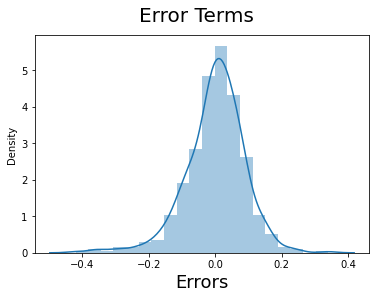

In [142]:
# Residual analysis
Y_train_pred = lr_model_4.predict(X_train_rfe_sm)
fig = plt.figure()
sns.distplot((Y_train - Y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Prediction and Evaluation against test set

In [144]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered','cnt']
# transform the test set
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.describe()

,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light_rain,weathersit_mist
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.266436,0.529076,0.522154,...,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000,0.027273,0.318182
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.216751,0.219300,0.219163,...,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.002133,0.059486,0.048205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.102484,0.359190,0.378595,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.225236,0.527577,0.524678,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.361780,0.667088,0.677750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,1.038708,0.985273,0.963300,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [146]:
# test set split for predictor and target variable
y_test = df_test.pop('cnt')
x_test = df_test

In [149]:
# Creating X_test_new dataframe by dropping variables from X_test
x_test_new = x_test[X_train_rfe.columns]

# Adding a constant variable 
x_test_new_sm = sm.add_constant(x_test_new)

# Making predictions
y_test_pred = lr_model_4.predict(x_test_new_sm)

## Model Evaluation

In [166]:
# r-squared value on the train set
print(r2_score(Y_train, Y_train_pred))
# r-squared value on the test set
print(r2_score(y_test, y_test_pred))

0.8398780502841431
0.8083066646304541


Text(0, 0.5, 'y_pred')

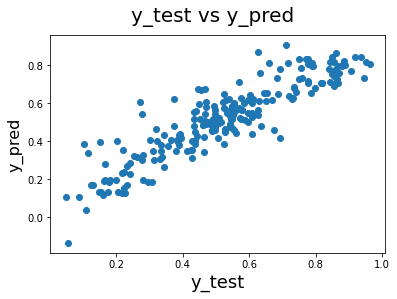

In [167]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label